# TAA PROJECT

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import os
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from PIL import Image
import scipy.misc

import pandas as pd

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

2022-06-28 15:51:11.315316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 15:51:11.315412: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and Process Data

All data should be in the folder "data". Training data should be in the sub-folder "training_data" and test data in "test_data". The csv should be inside the data folder.

In [2]:
c = 0
X_train_orig = []
y_train_orig = []

COMPRESS_RATE = (64,64)

X_test_orig = []
y_test_orig = []

path_train = "data/training_data/"
path_test = "data/test_data/"

tmp1 = pd.read_csv("data/ISBI2016_ISIC_Part3_Training_GroundTruth.csv", header=None, names=['id', 'class'])
tmp2 = pd.read_csv("data/ISBI2016_ISIC_Part3_Test_GroundTruth.csv", header=None, names=['id', 'class'])

training_truth = { tmp1['id'][i]: tmp1['class'][i] for i in range(tmp1.shape[0])}
test_truth = { tmp2['id'][i]: tmp2['class'][i] for i in range(tmp2.shape[0])}

for filename in os.listdir(path_train):

    y_train_orig.append(training_truth[filename.rstrip('.jpg')] == 'benign')

    image = Image.open(path_train + filename)
    data =  np.asarray(image)
    #plt.figure(c)
    #plt.imshow(data)
    data = image.resize(COMPRESS_RATE, Image.BICUBIC)
    #print(data.size)
    data =  np.asarray(data)
    #plt.figure(c+100)
    #plt.imshow(data)
    #print(data.shape)
    X_train_orig.append(data) 
    #if c > 10:
    #    break
    c += 1
    image.close()

for filename in os.listdir(path_test):

    y_test_orig.append(test_truth[filename.rstrip('.jpg')])

    image = Image.open(path_test + filename)
    data =  np.asarray(image)
    data = image.resize(COMPRESS_RATE, Image.BICUBIC)
    data =  np.asarray(data)
    X_test_orig.append(data) 
    image.close()

X_train_orig = np.array(X_train_orig)  
y_train_orig = np.array(y_train_orig)

X_test_orig = np.array(X_test_orig)  
y_test_orig = np.array(y_test_orig)

#print(X_train_orig.shape)
#print(y_train_orig.shape)


In [3]:
y_train = y_train_orig
y_test = y_test_orig

X_train = X_train_orig/225
X_test = X_test_orig/225

print ("X_train shape: ", X_train.shape)

print ("Y_train shape: ", y_train.shape)

print ("X_test shape: ", X_test.shape)

print ("Y_test shape: ", y_test.shape )



X_train shape:  (900, 64, 64, 3)
Y_train shape:  (900,)
X_test shape:  (379, 64, 64, 3)
Y_test shape:  (379,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


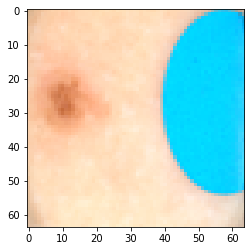

In [4]:
plt.imshow(X_train[0])

In [4]:
def myModel(input_shape):
    """ 
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    #Conv2D(filters, kernel_size, .... data_format='channels_last',...)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    
    #Normalize the activations of the previous layer at each batch, i.e. applies a transformation     that maintains the mean activation close to 0 and activation standard deviation close to 1.
    # If data_format="channels_last", the axis to be normalized is axis=3. 
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL: helps to lower the dimension of X in height and width.
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Creates the Keras model instance (object), you'll use to train/test the model.
    print(X_input)
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model

In [5]:
model = myModel(X_train.shape[1:])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


2022-06-28 15:52:25.297519: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-28 15:52:25.297544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dinis-lei): /proc/driver/nvidia/version does not exist
2022-06-28 15:52:25.298046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=["accuracy"])

In [7]:
model.fit(X_train, y_train, epochs=5, batch_size=None)

Epoch 1/5
29/29 [==============================] - 2s 64ms/step - loss: 1.1907 - accuracy: 0.7422
Epoch 2/5
29/29 [==============================] - 2s 59ms/step - loss: 0.7304 - accuracy: 0.7478
Epoch 3/5
29/29 [==============================] - 2s 58ms/step - loss: 0.4773 - accuracy: 0.7989
Epoch 4/5
29/29 [==============================] - 2s 58ms/step - loss: 0.5615 - accuracy: 0.7689
Epoch 5/5
29/29 [==============================] - 2s 58ms/step - loss: 0.5872 - accuracy: 0.7967


In [8]:
score = model.evaluate(X_train, y_train, batch_size=None)

print ("Loss =  ", score[0] )

print (" Accuracy on Train data = ", score[1] )

29/29 [==============================] - 1s 14ms/step - loss: 0.4164 - accuracy: 0.8311
Loss =   0.41641852259635925
 Accuracy on Train data =  0.8311111330986023


In [10]:
# 4.2 Evaluate the model on test data  
score = model.evaluate(X_test, y_test, batch_size=None)


print ("Loss =  ", score[0] )

print (" Accuracy on Test data = ", score[1] )


12/12 [==============================] - 0s 14ms/step - loss: 1.4458 - accuracy: 0.1926
Loss =   1.4458273649215698
 Accuracy on Test data =  0.19261214137077332


In [11]:
model.summary()

Model: "HappyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 70, 70, 3)        0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pool (MaxPooling2D)     (None, 32, 32, 32)        0         
                                                        